# Advanced Regression Assignment

In [1]:
# importing necessary libraries
import pandas as pd, numpy as np

#importing below libraries to visualize data
import matplotlib.pyplot as plt 
import seaborn as sns

#to split data into train data and test data
from sklearn.model_selection import train_test_split

#to rescale features
from sklearn.preprocessing import StandardScaler

#Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading the dataset as master_df
master_df = pd.read_csv('train.csv')
df = master_df.copy()  
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Understanding the Data Dictionary
`Please find details for all variables here `
[Data Dictionary](https://cdn.upgrad.com/UpGrad/temp/87f67e28-c47e-4725-ae3c-111142c7eaba/data_description.txt)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# finding the columns with categorical data
cols = df.columns
n_cols = df._get_numeric_data().columns
n_cols 
cat_cols=list(set(cols) - set(n_cols))

print('{0} - Categorical Columns \n{1} - Numerical Columns'.format(len(cat_cols),len(n_cols)))

43 - Categorical Columns 
38 - Numerical Columns


### After analysing both Data dictionary and the info the following can be inferred
#### 1. Total Categorical variables - 43
#### 2. Total Numeric variables - 38 of which 3 categorical columns are misclassified
#### 3. Misclassified i.e. features which are categorical as per dictionary but are of numeric type in dataframe  
> **MSSubClass**<br>
> **OverallQual**<br>
> **OverallCond**<br>

In [5]:
# converting misclassified numeric columns to categorical as per Data Dictionary
misclass = ['MSSubClass','OverallQual','OverallCond']
for col in misclass:
        df[col] = df[col].astype('object')
df[misclass].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MSSubClass   1460 non-null   object
 1   OverallQual  1460 non-null   object
 2   OverallCond  1460 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [6]:
df.describe().T #Transposing for a better readability

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0


In [7]:
# Fetching columns with all null values and the missing percentage
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [8]:
# PoolQC, MiscFeature, Alley are having more than 90% of the values misisng. 
# So droppinng these columns along with ID column
df = df.drop(columns=['Id','PoolQC','MiscFeature','Alley'])
df.shape

(1460, 77)

In [9]:
#Remaining columns with missing values
null_col = df.columns[df.isnull().any()]
df[null_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   MasVnrType    1452 non-null   object 
 2   MasVnrArea    1452 non-null   float64
 3   BsmtQual      1423 non-null   object 
 4   BsmtCond      1423 non-null   object 
 5   BsmtExposure  1422 non-null   object 
 6   BsmtFinType1  1423 non-null   object 
 7   BsmtFinType2  1422 non-null   object 
 8   Electrical    1459 non-null   object 
 9   FireplaceQu   770 non-null    object 
 10  GarageType    1379 non-null   object 
 11  GarageYrBlt   1379 non-null   float64
 12  GarageFinish  1379 non-null   object 
 13  GarageQual    1379 non-null   object 
 14  GarageCond    1379 non-null   object 
 15  Fence         281 non-null    object 
dtypes: float64(3), object(13)
memory usage: 182.6+ KB


## Treating Missing Values for numerical features

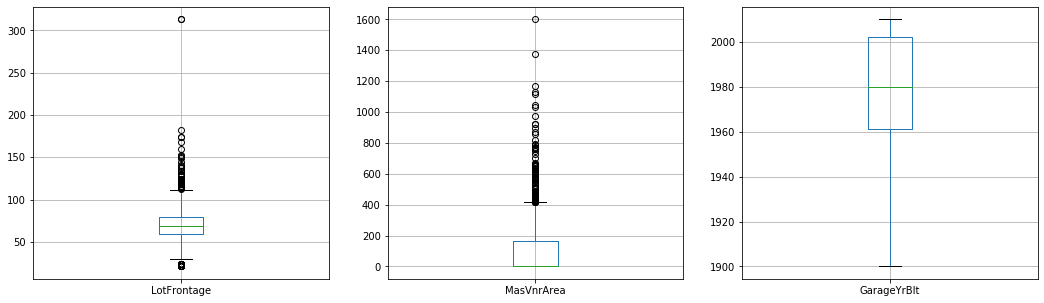

In [10]:
#Checking for outliers in 3 numeric columns 'LotFrontage','MasVnrArea','GarageYrBlt' using boxplot

plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
df.boxplot(column='LotFrontage', return_type='axes');
plt.subplot(1,3,2)
df.boxplot(column='MasVnrArea', return_type='axes');
plt.subplot(1,3,3)
df.boxplot(column='GarageYrBlt', return_type='axes');

### Apparently 'LotFrontage','MasVnrArea' has outliers. So imputing the missing values with median

### For 'GarageYrBlt', mean 1978.5 and the median is 1980. So we can impute the missing values using any of them



In [11]:
# filling the missing values with median
tempnumcols = ['LotFrontage','MasVnrArea','GarageYrBlt']
for col in tempnumcols:
    df[col].fillna(df[col].median(),inplace=True)

In [12]:
# verifying for the null values after imputation
df[tempnumcols].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [13]:
#Remaining columns with missing values
null_col = df.columns[df.isnull().any()]
df[null_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MasVnrType    1452 non-null   object
 1   BsmtQual      1423 non-null   object
 2   BsmtCond      1423 non-null   object
 3   BsmtExposure  1422 non-null   object
 4   BsmtFinType1  1423 non-null   object
 5   BsmtFinType2  1422 non-null   object
 6   Electrical    1459 non-null   object
 7   FireplaceQu   770 non-null    object
 8   GarageType    1379 non-null   object
 9   GarageFinish  1379 non-null   object
 10  GarageQual    1379 non-null   object
 11  GarageCond    1379 non-null   object
 12  Fence         281 non-null    object
dtypes: object(13)
memory usage: 148.4+ KB


### 1. 'MasVnrType'

In [14]:
df[df['MasVnrType'] == 'None'][['MasVnrType','MasVnrArea']]

# After analysis MasVnrArea values are zero for MasVnrType of 'None' type
# And MasVnrArea values are zero for all missing values rows of MasVnrType
# So replacing MasVnrType with 'None'

df['MasVnrType'].fillna('None',inplace=True)

### 2. 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2'

In [15]:
# Now analysing 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2' all Basement related columns
df[df['BsmtQual'].isnull()][['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF
17,NaN,NaN,NaN,NaN,0,NaN,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0


In [16]:
# After analysis the above columns are because of No Basement
# So replacing all NAN values with 'NoBsmt'
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2']

for col in bsmt_cols:
    df[col].fillna('NoBsmt',inplace=True)


### 3. 'Electrical'

In [17]:
# Electrical column is having only one missing value so replacing it with mode()
df['Electrical'].fillna(df['Electrical'].mode(0)[0],inplace=True)

### 4. 'FireplaceQu'

In [18]:
# As per Data Dictionary NA means "no fireplace"
# So replacing all NAN values with 'NoFireplace'
df["FireplaceQu"] = df["FireplaceQu"].fillna("NoFireplace")

### 5. 'GarageType','GarageFinish', 'GarageQual','GarageCond'

In [19]:
# After analysis the above columns are because of No Garage
# So replacing all NAN values with 'No Garage'
gar_cols = ['GarageType','GarageFinish', 'GarageQual','GarageCond']

for col in gar_cols:
    df[col].fillna('NoGarage',inplace=True)

### 6. 'Fence'

In [20]:
# As per Data Dictionary NA means "No Fence"
# So replacing all NAN values with 'NoFence'
df["Fence"] = df["Fence"].fillna("NoFence")

## EDA and Data Preparation

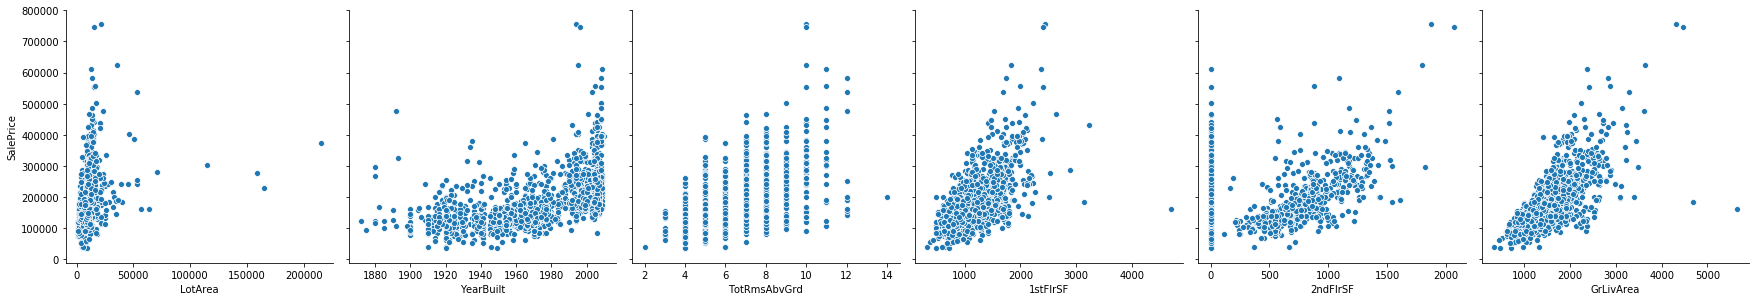

In [21]:
#visualizing the data to identify if some predictors are associated with SalePrice
sns.pairplot(df, x_vars=['LotArea', 'YearBuilt', 'TotRmsAbvGrd','1stFlrSF', '2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',size=4, aspect=1, kind='scatter')
plt.show()

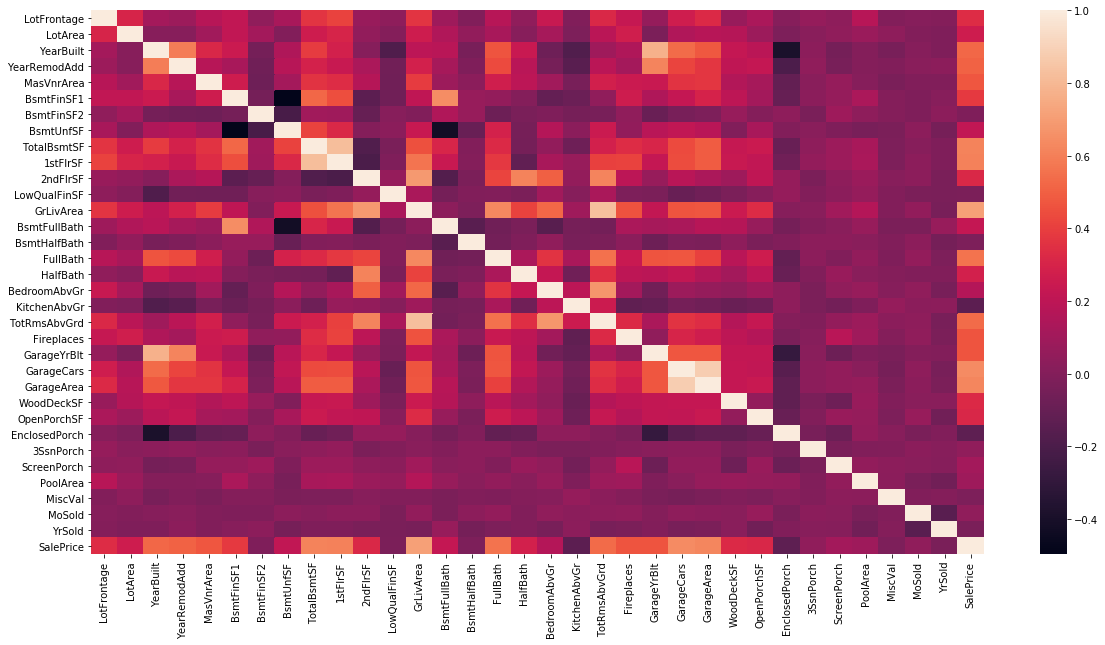

In [22]:
#finding the correlation matrix between numeric variables using heatmap
plt.figure(figsize=(20,10))
sns.heatmap(df.corr())
plt.show()

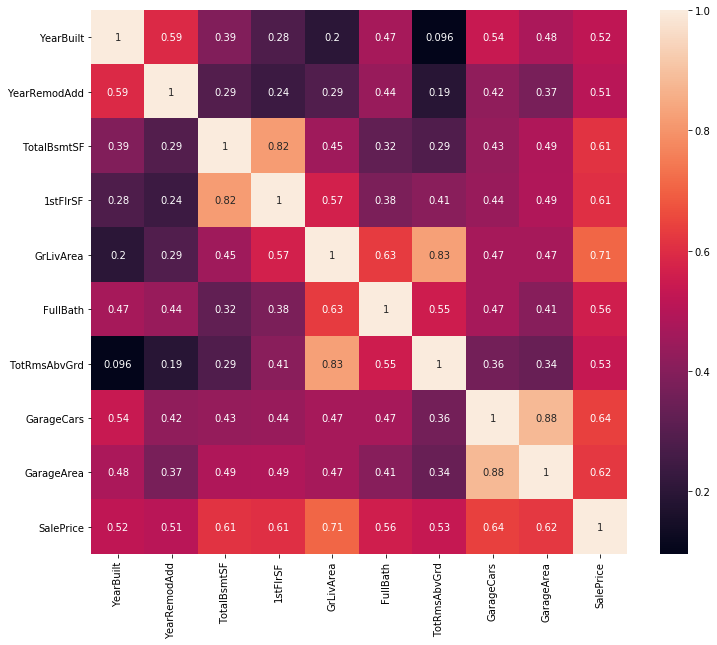

In [23]:
# Most correlated variables
corrmat = df.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(12,10))
g = sns.heatmap(df[top_corr_features].corr(),annot=True)

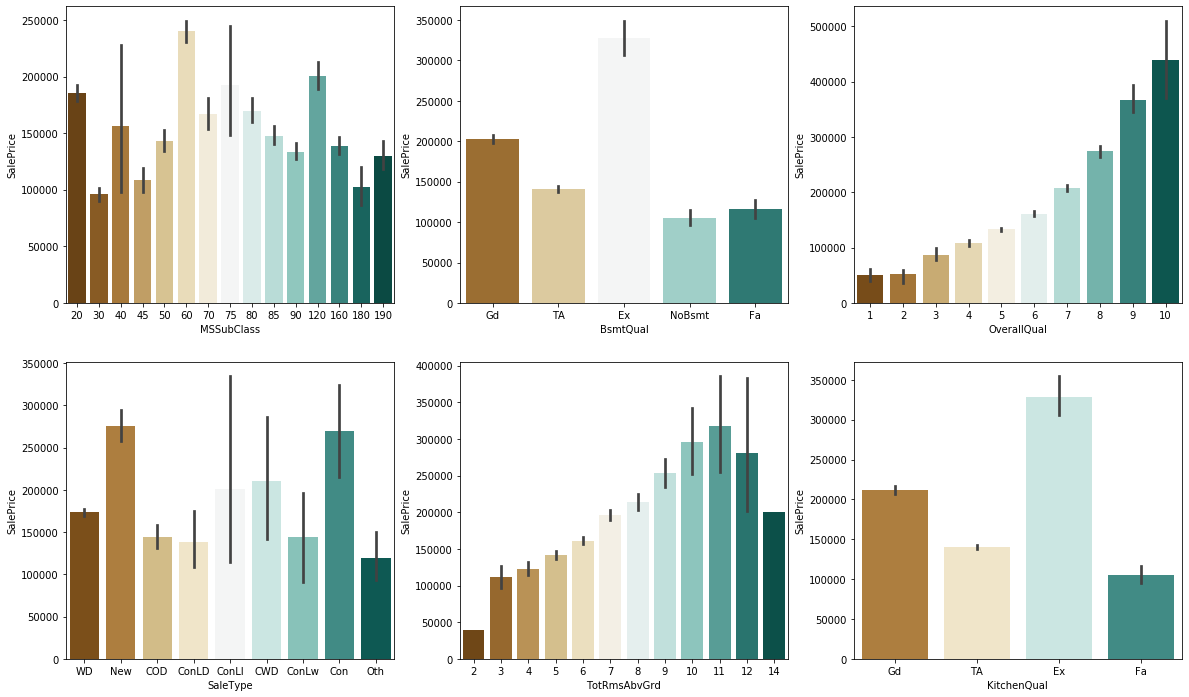

In [24]:
#Analysing some categorical features with respect to SalePrice
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.barplot(x = 'MSSubClass' , y = 'SalePrice', data = df , palette='BrBG')
plt.subplot(2,3,2)
sns.barplot(x = 'BsmtQual', y = 'SalePrice', data = df , palette='BrBG')
plt.subplot(2,3,3)
sns.barplot(x = 'OverallQual', y = 'SalePrice', data = df , palette='BrBG')
plt.subplot(2,3,4)
sns.barplot(x = 'SaleType', y = 'SalePrice', data = df , palette='BrBG')
plt.subplot(2,3,5)
sns.barplot(x = 'TotRmsAbvGrd', y = 'SalePrice', data = df , palette='BrBG')
plt.subplot(2,3,6)
sns.barplot(x = 'KitchenQual', y = 'SalePrice', data = df , palette='BrBG')
plt.show()

### Analysing Target variable 

Text(0, 0.5, 'Frequency')

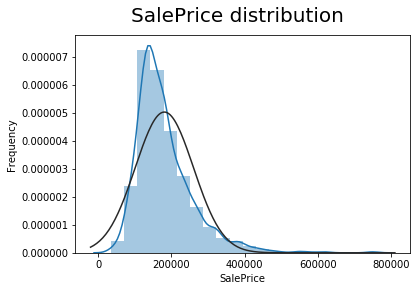

In [25]:
# Plot the histogram of the SalePrice
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import norm
fig = plt.figure()
sns.distplot(df['SalePrice'], bins = 20,fit = norm)
fig.suptitle('SalePrice distribution', fontsize = 20)                  # Plot heading 
plt.ylabel('Frequency', fontsize = 10)                         # X-label

In [26]:
#Log transformation - log(1+x) to account for smaller rounding errors
df['SalePrice'] = np.log1p(df['SalePrice'])

Text(0, 0.5, 'Frequency')

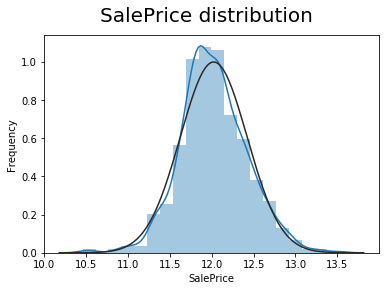

In [27]:
fig = plt.figure()
sns.distplot(df['SalePrice'], bins = 20,fit = norm)
fig.suptitle('SalePrice distribution', fontsize = 20)                  # Plot heading 
plt.ylabel('Frequency', fontsize = 10)

### Data Preparation

In [28]:
# As per Data Dictionary renaming values of MSSubClass 
df = df.replace({'MSSubClass' : {        20: '1-STORY 1946 & NEWER ALL STYLES', 
                                          30:'1-STORY 1945 & OLDER',
                                          40:'1-STORY W/FINISHED ATTIC ALL AGES',
                                          45:'1-1/2 STORY - UNFINISHED ALL AGES',
                                          50:'1-1/2 STORY FINISHED ALL AGES',
                                          60:'2-STORY 1946 & NEWER',
                                          70:'2-STORY 1945 & OLDER',
                                          75:'2-1/2 STORY ALL AGES',
                                          80:'SPLIT OR MULTI-LEVEL',
                                          85:'SPLIT FOYER',
                                          90:'DUPLEX - ALL STYLES AND AGES',
                                         120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
                                         150:'1-1/2 STORY PUD - ALL AGES',
                                         160:'2-STORY PUD - 1946 & NEWER',
                                         180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
                                         190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}})

df = df.replace({'OverallQual' : {        10: 'Very Excellent', 
                                          9:'Excellent',
                                          8:'Very Good',
                                          7:'Good',
                                          6:'Above Average',
                                          5:'Average',
                                          4:'Below Average',
                                          3:'Fair',
                                          2:'Poor',
                                          1:'Very Poor' }})

df = df.replace({'OverallCond' : {        10: 'Very Excellent', 
                                          9:'Excellent',
                                          8:'Very Good',
                                          7:'Good',
                                          6:'Above Average',
                                          5:'Average',
                                          4:'Below Average',
                                          3:'Fair',
                                          2:'Poor',
                                          1:'Very Poor' }})

In [29]:
# fetching all numeric columns
numeric_features = df.select_dtypes(include=[np.number])

In [30]:
# fetching all categorical columns
categorical_features = df.select_dtypes(include=[np.object])

In [31]:
#taking a copy for further analysis
new_df = df.copy()

### Feature Engineering

In [32]:
# Label Encoding categorical features
columns = categorical_features.columns
from sklearn.preprocessing import LabelEncoder
# Apply LabelEncoder to all columns above
for i in columns:
    lbl = LabelEncoder() 
    lbl.fit(list(df[i].values)) 
    df[i] = lbl.transform(list(df[i].values))

In [33]:
# creating dummies for categorical variables
df_dummies = pd.get_dummies(categorical_features, drop_first=True)
df_dummies.shape

(1460, 245)

In [34]:
#concatenating dummy columns to original dataframe
df = pd.concat([df,df_dummies], axis=1)

In [35]:
#dropping original categorical columns
df = df.drop(list(categorical_features.columns), axis=1)

In [36]:
y = df.pop('SalePrice')
X = df

## Splitting the Data into Training and Testing Sets

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [38]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [39]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,20)
rfe = rfe.fit(X_train,y_train)

In [40]:
#fetching all informative features along with rank
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 239),
 ('LotArea', False, 256),
 ('YearBuilt', False, 233),
 ('YearRemodAdd', False, 238),
 ('MasVnrArea', False, 253),
 ('BsmtFinSF1', False, 32),
 ('BsmtFinSF2', False, 34),
 ('BsmtUnfSF', False, 33),
 ('TotalBsmtSF', False, 27),
 ('1stFlrSF', False, 29),
 ('2ndFlrSF', False, 28),
 ('LowQualFinSF', False, 30),
 ('GrLivArea', False, 31),
 ('BsmtFullBath', False, 143),
 ('BsmtHalfBath', False, 228),
 ('FullBath', False, 170),
 ('HalfBath', False, 190),
 ('BedroomAbvGr', False, 240),
 ('KitchenAbvGr', False, 26),
 ('TotRmsAbvGrd', False, 250),
 ('Fireplaces', False, 237),
 ('GarageYrBlt', False, 254),
 ('GarageCars', False, 99),
 ('GarageArea', False, 245),
 ('WoodDeckSF', False, 252),
 ('OpenPorchSF', False, 249),
 ('EnclosedPorch', False, 251),
 ('3SsnPorch', False, 246),
 ('ScreenPorch', False, 248),
 ('PoolArea', False, 244),
 ('MiscVal', False, 255),
 ('MoSold', False, 242),
 ('YrSold', False, 236),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', False, 61),
 

In [41]:
#fetching all features that support
col = X_train.columns[rfe.support_]
col

Index(['OverallQual_Very Poor', 'OverallCond_Very Poor', 'Exterior1st_AsphShn',
       'Exterior2nd_AsphShn', 'BsmtQual_NoBsmt', 'BsmtCond_NoBsmt',
       'BsmtCond_Po', 'BsmtFinType1_NoBsmt', 'GarageType_NoGarage',
       'GarageFinish_NoGarage', 'GarageQual_Fa', 'GarageQual_Gd',
       'GarageQual_NoGarage', 'GarageQual_Po', 'GarageQual_TA',
       'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_NoGarage',
       'GarageCond_Po', 'GarageCond_TA'],
      dtype='object')

In [42]:
#creating train dataset with RFE selected variables
X_train_rfe = X_train[col]

In [43]:
#adding constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

In [44]:
#running first linearmodel
lm1 = sm.OLS(y_train,X_train_rfe).fit()

In [45]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     19.79
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           1.96e-36
Time:                        23:29:53   Log-Likelihood:                -404.43
No. Observations:                1021   AIC:                             832.9
Df Residuals:                    1009   BIC:                             892.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.7559      0.362     32.501      0.000      11.046      12.466
OverallQual_Very Poor    -0.1879      0.122     -1.545      0.123      -0.427       0.051
OverallCond_Very Poor    -0.1879      0.122     -1.545      0.123      -0.427       0.051
Exterior1st_AsphShn       0.1739      0.185      0.938      0.348      -0.190       0.538
Exterior2nd_AsphShn       0.1739      0.185      0.938      0.348      -0.190       0.538
BsmtQual_NoBsmt          -0.1391      0.023     -5.985      0.000      -0.185      -0.093
BsmtCond_NoBsmt          -0.1391      0.023     -5.985      0.000      -0.185      -0.093
BsmtCond_Po              -0.1879      0.122     -1.545      0.123      -0.427       0.051
BsmtFinType1_NoBsmt      -0.1391      0.023     -5.985      0.000      -0.185      -0.093
GarageType_NoGarage      -0.0434      0.091     -0.475      0.635      -0.222       0.136
GarageFinish_NoGarage    -0.0434      0.091     -0.475      0.635      -0.222       0.136
GarageQual_Fa            -0.1796      0.198     -0.907      0.365      -0.568       0.209
GarageQual_Gd             0.3710      0.221      1.676      0.094      -0.063       0.805
GarageQual_NoGarage      -0.0434      0.091     -0.475      0.635      -0.222       0.136
GarageQual_Po            -0.1486      0.332     -0.448      0.654      -0.800       0.502
GarageQual_TA             0.1266      0.196      0.644      0.520      -0.259       0.512
GarageCond_Fa            -0.1025      0.203     -0.505      0.614      -0.501       0.296
GarageCond_Gd             0.0285      0.234      0.121      0.903      -0.431       0.488
GarageCond_NoGarage      -0.0434      0.091     -0.475      0.635      -0.222       0.136
GarageCond_Po             0.0453      0.247      0.183      0.855      -0.439       0.530
GarageCond_TA             0.1981      0.196      1.009      0.313      -0.187       0.583
==============================================================================
Omnibus:                       31.040   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.477
Skew:                           0.259   Prob(JB):                     1.80e-11
Kurtosis:                       3.946   Cond. No.                     5.06e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Ridge and Lasso Regression

## Ridge Regression

In [46]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    4.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [47]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017397,0.005648,0.002463,0.003257,0.0001,{'alpha': 0.0001},-0.091308,-0.092960,-0.096522,-0.102768,...,-0.094425,0.004902,15,-0.051291,-0.052752,-0.052285,-0.052092,-0.052895,-0.052263,0.000568
1,0.018353,0.003546,0.001193,0.001926,0.001,{'alpha': 0.001},-0.091157,-0.092914,-0.096318,-0.102281,...,-0.094200,0.004800,13,-0.051383,-0.052758,-0.052339,-0.052161,-0.052996,-0.052327,0.000557
2,0.016202,0.002056,0.005311,0.003260,0.01,{'alpha': 0.01},-0.090471,-0.092551,-0.095531,-0.098834,...,-0.092959,0.003957,10,-0.052597,-0.052840,-0.053435,-0.053023,-0.054324,-0.053244,0.000606
3,0.017806,0.004945,0.002673,0.003661,0.05,{'alpha': 0.05},-0.091571,-0.091994,-0.098379,-0.095736,...,-0.093763,0.002830,12,-0.056719,-0.053225,-0.057266,-0.057064,-0.058701,-0.056595,0.001816
4,0.021348,0.005399,0.003972,0.006430,0.1,{'alpha': 0.1},-0.093358,-0.092067,-0.099914,-0.095406,...,-0.095033,0.002681,21,-0.059357,-0.053702,-0.059458,-0.059948,-0.061444,-0.058782,0.002647
5,0.026777,0.009954,0.000000,0.000000,0.2,{'alpha': 0.2},-0.094385,-0.092523,-0.100749,-0.094565,...,-0.095668,0.002785,25,-0.061861,-0.054604,-0.061401,-0.062664,-0.064001,-0.060906,0.003272
6,0.015864,0.000479,0.003124,0.006247,0.3,{'alpha': 0.3},-0.094372,-0.092777,-0.100939,-0.093750,...,-0.095611,0.002891,24,-0.063244,-0.055393,-0.062376,-0.064064,-0.065346,-0.062085,0.003486
7,0.015908,0.000548,0.003119,0.006237,0.4,{'alpha': 0.4},-0.094165,-0.093005,-0.100932,-0.093150,...,-0.095440,0.002940,23,-0.064196,-0.056051,-0.062981,-0.064992,-0.066247,-0.062893,0.003582
8,0.021113,0.004727,0.002120,0.002311,0.5,{'alpha': 0.5},-0.093861,-0.093117,-0.100884,-0.092623,...,-0.095206,0.003006,22,-0.064906,-0.056630,-0.063414,-0.065716,-0.066940,-0.063521,0.003631
9,0.024820,0.004854,0.004571,0.005765,0.6,{'alpha': 0.6},-0.093506,-0.093181,-0.100848,-0.092281,...,-0.094984,0.003071,20,-0.065477,-0.057132,-0.063745,-0.066303,-0.067511,-0.064034,0.003662


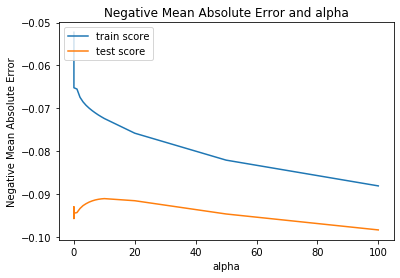

In [48]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [49]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'alpha': 10.0}
-0.09103515813879864


In [50]:
# choosing alpha as 10 which is optimum
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-4.34904975e-04,  1.86291247e-06,  1.66626332e-03,  1.45145595e-03,
        5.29984968e-06, -1.36956682e-05,  4.07235122e-05, -2.94908547e-06,
        2.40787538e-05,  7.52533906e-05,  1.09710698e-04, -2.50172751e-05,
        1.59946803e-04,  4.28434455e-02,  6.55100682e-03,  3.84029063e-02,
        2.01843091e-02,  8.51953798e-03, -5.85528848e-02,  5.99245342e-03,
        9.46069461e-03, -2.93562390e-04,  5.40625713e-02,  2.59842292e-05,
        1.05902155e-04,  2.12670850e-05,  1.39169202e-04,  2.30162159e-04,
        2.13605126e-04, -4.36153147e-04,  1.26611885e-07, -3.03011853e-04,
       -4.74025635e-03,  1.51551629e-02, -5.40673384e-02,  3.95581705e-02,
       -3.10849434e-04, -2.12713575e-03, -8.90893903e-03,  3.65011716e-02,
        5.43273751e-02, -3.22834517e-02, -6.17732770e-02,  8.28171496e-03,
       -3.17497960e-02,  2.07435926e-02,  6.59028117e-03,  6.34626763e-02,
        4.18598318e-02,  6.69110408e-02,  1.98897869e-02,  2.85169715e-02,
        2.35030863e-02, -

In [51]:
coeff = pd.DataFrame(ridge.coef_,X_train.columns, columns=['Coefficient'])
print(coeff.sort_values(by='Coefficient'))

                       Coefficient
OverallCond_Fair         -0.110710
Condition2_PosN          -0.088391
Neighborhood_Edwards     -0.080765
OverallQual_Poor         -0.076117
Neighborhood_MeadowV     -0.062398
...                            ...
Neighborhood_Somerst      0.070634
Neighborhood_NridgHt      0.083926
OverallQual_Very Good     0.089988
Neighborhood_Crawfor      0.091704
OverallQual_Excellent     0.130432

[278 rows x 1 columns]


In [52]:
#lets predict the R-squared value of test and train data
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

0.9242028261350649


In [53]:
print(coeff.sort_values(by='Coefficient').head(3))

                      Coefficient
OverallCond_Fair        -0.110710
Condition2_PosN         -0.088391
Neighborhood_Edwards    -0.080765


In [54]:
print(coeff.sort_values(by='Coefficient').tail(3))

                       Coefficient
OverallQual_Very Good     0.089988
Neighborhood_Crawfor      0.091704
OverallQual_Excellent     0.130432


In [55]:
scaler.fit(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [56]:
#lets predict the R-squared value of test and train data
y_test_pred = ridge.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8796393716677912


In [57]:
print('The accuracy of the Ridge Regression is',r2_score(y_test,y_test_pred))
print ('RMSE is: ', mean_squared_error(y_test, y_test_pred))

The accuracy of the Ridge Regression is 0.8796393716677912
RMSE is:  0.019803887137030754


### Doubling alpha for Ridge

In [58]:
alpha = 10*2
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_
coeff = pd.DataFrame(ridge.coef_,X_train.columns, columns=['Coefficient'])
print(coeff.sort_values(by='Coefficient'))

                                       Coefficient
OverallCond_Fair                         -0.080342
Neighborhood_Edwards                     -0.073275
MSSubClass_2-STORY PUD - 1946 & NEWER    -0.050266
Condition2_PosN                          -0.049602
BldgType_Twnhs                           -0.049000
...                                            ...
CentralAir_Y                              0.057372
Neighborhood_NridgHt                      0.069466
Neighborhood_Crawfor                      0.074826
OverallQual_Very Good                     0.077418
OverallQual_Excellent                     0.099701

[278 rows x 1 columns]


In [59]:
#lets predict the R-squared value of test and train data
y_train_pred = ridge.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

0.9157048683879335


In [60]:
print(coeff.sort_values(by='Coefficient').head(3))

                                       Coefficient
OverallCond_Fair                         -0.080342
Neighborhood_Edwards                     -0.073275
MSSubClass_2-STORY PUD - 1946 & NEWER    -0.050266


In [61]:
print(coeff.sort_values(by='Coefficient').tail(3))

                       Coefficient
Neighborhood_Crawfor      0.074826
OverallQual_Very Good     0.077418
OverallQual_Excellent     0.099701


In [62]:
scaler.fit(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [63]:
#lets predict the R-squared value of test and train data
y_test_pred = ridge.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.875187170572742


In [64]:
print('The accuracy of the Ridge Regression is',r2_score(y_test,y_test_pred))
print ('RMSE is: ', mean_squared_error(y_test, y_test_pred))

The accuracy of the Ridge Regression is 0.875187170572742
RMSE is:  0.020536443033584883


## Lasso

In [65]:
# list of alphas to tune
param = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 1]}

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = param, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [66]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.251064,0.061555,0.004108,0.003974,0.0001,{'alpha': 0.0001},-0.085749,-0.088110,-0.097155,-0.092277,...,-0.089300,0.004933,1,-0.060734,-0.056983,-0.060503,-0.059718,-0.062880,-0.060164,0.001905
1,0.070669,0.012933,0.001760,0.001808,0.001,{'alpha': 0.001},-0.085048,-0.093944,-0.102994,-0.087699,...,-0.090746,0.007027,2,-0.078674,-0.071756,-0.074469,-0.078475,-0.080366,-0.076748,0.003159
2,0.039984,0.026231,0.004778,0.002465,0.01,{'alpha': 0.01},-0.107375,-0.126537,-0.127143,-0.107026,...,-0.116428,0.008865,3,-0.115780,-0.103643,-0.109924,-0.115927,-0.113585,-0.111772,0.004607
3,0.135929,0.009397,0.002443,0.002993,0.05,{'alpha': 0.05},-0.111995,-0.128205,-0.129536,-0.111356,...,-0.119113,0.008046,6,-0.118796,-0.106401,-0.112549,-0.119403,-0.119003,-0.115230,0.005089
4,0.095790,0.037023,0.003087,0.003430,0.1,{'alpha': 0.1},-0.111799,-0.127817,-0.129295,-0.111393,...,-0.118966,0.007918,5,-0.118659,-0.106413,-0.112393,-0.119173,-0.119045,-0.115137,0.005052


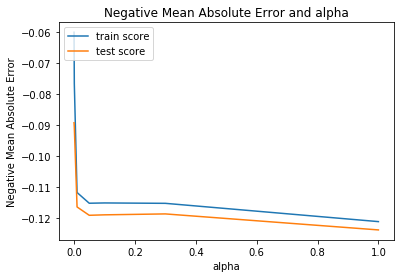

In [67]:
# plotting mean test and train scores with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float64')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [68]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'alpha': 0.0001}
-0.08930006802236927


In [69]:
# choosing alpha as 0.0001 which is optimum
alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([-1.68250632e-04,  2.08024910e-06,  1.84826101e-03,  1.30685708e-03,
        1.19429503e-05,  3.45760217e-05,  6.20807789e-05,  2.26767542e-05,
        1.43709850e-05,  2.23005144e-04,  2.36216960e-04,  1.02524421e-04,
        2.88040812e-05,  3.63257076e-02,  1.03339376e-03,  2.98321741e-02,
        1.37490811e-02,  4.68081346e-03, -7.49352313e-02,  2.10761423e-03,
       -3.90933089e-03, -1.98703118e-04,  5.06361998e-02,  1.16593257e-05,
        8.01885571e-05,  8.58287381e-05,  1.14079368e-04,  1.92198662e-04,
        1.77856935e-04, -2.50463398e-04, -1.35983987e-06, -5.25435940e-05,
       -3.28635283e-03,  1.01954829e-02, -7.21414218e-02,  2.82002295e-02,
       -2.22570612e-03, -0.00000000e+00, -2.12542905e-02,  1.06555570e-02,
        3.24166330e-02, -3.25194151e-02, -9.23442588e-02,  6.84851982e-03,
       -3.92358265e-02,  5.92563791e-03,  0.00000000e+00,  3.35704841e-01,
        3.09978863e-01,  3.17993245e-01,  2.66444089e-01,  4.03543918e-02,
        1.40282318e-02, -

In [70]:
coeff = pd.DataFrame(lasso.coef_,X_train.columns, columns=['Coefficient'])
print(coeff.sort_values(by='Coefficient'))

                      Coefficient
Condition2_PosN         -1.226587
OverallQual_Poor        -0.329272
Functional_Sev          -0.175985
OverallCond_Fair        -0.167802
Neighborhood_MeadowV    -0.144851
...                           ...
RoofMatl_WdShake         0.852140
RoofMatl_Membran         0.853409
RoofMatl_Tar&Grv         0.882106
RoofMatl_CompShg         0.940177
RoofMatl_WdShngl         1.022446

[278 rows x 1 columns]


In [71]:
#lets predict the R-squared value of test and train data
y_train_pred_lasso = lasso.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred_lasso))

0.9505199232927366


In [72]:
print(coeff.sort_values(by='Coefficient').head(3))

                  Coefficient
Condition2_PosN     -1.226587
OverallQual_Poor    -0.329272
Functional_Sev      -0.175985


In [73]:
print(coeff.sort_values(by='Coefficient').tail(3))

                  Coefficient
RoofMatl_Tar&Grv     0.882106
RoofMatl_CompShg     0.940177
RoofMatl_WdShngl     1.022446


In [74]:
scaler.fit(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [75]:
#lets predict the R-squared value of test and train data
y_test_pred = lasso.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8707907708167675


In [76]:
print('The accuracy of the Lasso Regression is',r2_score(y_test,y_test_pred))
print ('RMSE is: ', mean_squared_error(y_test, y_test_pred))

The accuracy of the Lasso Regression is 0.8707907708167675
RMSE is:  0.021259817494012893


### Doubling alpha for Lasso

In [77]:
alpha =0.0001 * 2

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_
coeff = pd.DataFrame(lasso.coef_,X_train.columns, columns=['Coefficient'])
print(coeff.sort_values(by='Coefficient'))

                                       Coefficient
Condition2_PosN                          -0.984082
OverallQual_Poor                         -0.301449
OverallCond_Fair                         -0.170583
Neighborhood_MeadowV                     -0.137571
MSSubClass_2-STORY PUD - 1946 & NEWER    -0.093904
...                                            ...
MSZoning_RM                               0.192543
OverallQual_Excellent                     0.209231
MSZoning_RH                               0.236503
MSZoning_RL                               0.242188
MSZoning_FV                               0.252940

[278 rows x 1 columns]


In [78]:
#lets predict the R-squared value of test and train data
y_train_pred = lasso.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))

0.9378057376747676


In [79]:
print(coeff.sort_values(by='Coefficient').head(3))

                  Coefficient
Condition2_PosN     -0.984082
OverallQual_Poor    -0.301449
OverallCond_Fair    -0.170583


In [80]:
print(coeff.sort_values(by='Coefficient').tail(3))

             Coefficient
MSZoning_RH     0.236503
MSZoning_RL     0.242188
MSZoning_FV     0.252940


In [81]:
scaler.fit(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [82]:
#lets predict the R-squared value of test and train data
y_test_pred = lasso.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8680163046377225


In [83]:
print('The accuracy of the Lasso Regression is',r2_score(y_test,y_test_pred))
print ('RMSE is: ', mean_squared_error(y_test, y_test_pred))

The accuracy of the Lasso Regression is 0.8680163046377225
RMSE is:  0.02171632238133917


### Build another model after dropping top 5 features from Lasso regression
### Dropping RoofMatl_Tar&Grv, RoofMatl_CompShg, RoofMatl_WdShngl, Condition2_PosN, OverallQual_Poor  columns

In [84]:
# Label Encoding categorical features
columns = categorical_features.columns
from sklearn.preprocessing import LabelEncoder
# Apply LabelEncoder to all columns above
for i in columns:
    lbl = LabelEncoder() 
    lbl.fit(list(new_df[i].values)) 
    new_df[i] = lbl.transform(list(new_df[i].values))

# creating dummies for categorical variables
new_df_dummies = pd.get_dummies(categorical_features, drop_first=True)
new_df_dummies.shape

#concatenating dummy columns to original dataframe
new_df = pd.concat([new_df,new_df_dummies], axis=1)

#dropping original categorical columns
new_df = new_df.drop(list(categorical_features.columns), axis=1)

new_df = new_df.drop(columns=['RoofMatl_Tar&Grv', 'RoofMatl_CompShg', 'RoofMatl_WdShngl', 'Condition2_PosN', 'OverallQual_Poor' ])

y = new_df.pop('SalePrice')
X = new_df


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

scaler = StandardScaler()
scaler.fit(X_train)



StandardScaler(copy=True, with_mean=True, with_std=True)

In [86]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,20)
rfe = rfe.fit(X_train,y_train)

In [87]:
#fetching all informative features along with rank
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 236),
 ('LotArea', False, 249),
 ('YearBuilt', False, 228),
 ('YearRemodAdd', False, 230),
 ('MasVnrArea', False, 251),
 ('BsmtFinSF1', False, 243),
 ('BsmtFinSF2', False, 242),
 ('BsmtUnfSF', False, 245),
 ('TotalBsmtSF', False, 244),
 ('1stFlrSF', False, 214),
 ('2ndFlrSF', False, 215),
 ('LowQualFinSF', False, 216),
 ('GrLivArea', False, 213),
 ('BsmtFullBath', False, 113),
 ('BsmtHalfBath', False, 200),
 ('FullBath', False, 9),
 ('HalfBath', False, 65),
 ('BedroomAbvGr', False, 139),
 ('KitchenAbvGr', False, 189),
 ('TotRmsAbvGrd', False, 234),
 ('Fireplaces', False, 190),
 ('GarageYrBlt', False, 238),
 ('GarageCars', False, 50),
 ('GarageArea', False, 248),
 ('WoodDeckSF', False, 246),
 ('OpenPorchSF', False, 247),
 ('EnclosedPorch', False, 241),
 ('3SsnPorch', False, 239),
 ('ScreenPorch', False, 240),
 ('PoolArea', False, 232),
 ('MiscVal', False, 250),
 ('MoSold', False, 224),
 ('YrSold', False, 227),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', False, 

In [88]:
#fetching all features that support
col = X_train.columns[rfe.support_]
col

Index(['MSSubClass_1-STORY 1945 & OLDER',
       'MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_NoRidge',
       'OverallQual_Excellent', 'OverallQual_Good',
       'OverallQual_Very Excellent', 'OverallQual_Very Good',
       'OverallCond_Fair', 'RoofStyle_Shed', 'Exterior1st_Stone',
       'Exterior2nd_CBlock', 'BsmtCond_NoBsmt', 'BsmtCond_Po', 'Heating_GasA',
       'Heating_GasW', 'HeatingQC_Po'],
      dtype='object')

In [89]:
#creating train dataset with RFE selected variables
X_train_rfe = X_train[col]

#adding constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

#running first linearmodel
lm1 = sm.OLS(y_train,X_train_rfe).fit()

lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     129.0
Date:                Mon, 19 Oct 2020   Prob (F-statistic):          3.76e-260
Time:                        23:30:16   Log-Likelihood:                 146.86
No. Observations:                1021   AIC:                            -251.7
Df Residuals:                    1000   BIC:                            -148.2
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                 10.8897      0.108    100.955      0.000      10.678      11.101
MSSubClass_1-STORY 1945 & OLDER                       -0.3443      0.035     -9.923      0.000      -0.412      -0.276
MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER    -0.2787      0.088     -3.151      0.002      -0.452      -0.105
MSZoning_FV                                            0.6976      0.088      7.961      0.000       0.526       0.870
MSZoning_RH                                            0.6473      0.100      6.487      0.000       0.452       0.843
MSZoning_RL                                            0.7213      0.081      8.869      0.000       0.562       0.881
MSZoning_RM                                            0.5119      0.083      6.200      0.000       0.350       0.674
Neighborhood_NoRidge                                   0.2185      0.040      5.524      0.000       0.141       0.296
OverallQual_Excellent                                  0.8549      0.042     20.383      0.000       0.773       0.937
OverallQual_Good                                       0.3192      0.017     18.470      0.000       0.285       0.353
OverallQual_Very Excellent                             0.9531      0.059     16.289      0.000       0.838       1.068
OverallQual_Very Good                                  0.5662      0.023     25.087      0.000       0.522       0.610
OverallCond_Fair                                      -0.3355      0.058     -5.789      0.000      -0.449      -0.222
RoofStyle_Shed                                         0.2420      0.150      1.613      0.107      -0.052       0.536
Exterior1st_Stone                                      0.2634      0.150      1.754      0.080      -0.031       0.558
Exterior2nd_CBlock                                    -0.3483      0.212     -1.643      0.101      -0.764       0.068
BsmtCond_NoBsmt                                       -0.2569      0.042     -6.098      0.000      -0.340      -0.174
BsmtCond_Po                                           -0.5470      0.215     -2.550      0.011      -0.968      -0.126
Heating_GasA                                           0.2990      0.071      4.234      0.000       0.160       0.438
Heating_GasW                                           0.4017      0.091      4.398      0.000       0.222       0.581
HeatingQC_Po                                          -0.3269      0.213     -1.538      0.124      -0.744       0.090
==============================================================================
Omnibus:                        7.047   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.029   Jarque-Bera (JB):            

## Lasso

In [90]:
# list of alphas to tune
param = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 1]}

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = param, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    3.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.3, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [91]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.176525,0.064470,0.008284,0.006786,0.0001,{'alpha': 0.0001},-0.094617,-0.098087,-0.101609,-0.092991,...,-0.096195,0.003225,2,-0.069062,-0.060763,-0.065732,-0.070867,-0.070739,-0.067433,0.003815
1,0.045315,0.010352,0.003464,0.006927,0.001,{'alpha': 0.001},-0.085635,-0.094371,-0.102994,-0.088151,...,-0.091193,0.006785,1,-0.079581,-0.072955,-0.074469,-0.079217,-0.080867,-0.077418,0.003112
2,0.028839,0.006669,0.003521,0.006064,0.01,{'alpha': 0.01},-0.107375,-0.126537,-0.127143,-0.107026,...,-0.116428,0.008865,3,-0.115780,-0.103643,-0.109924,-0.115927,-0.113585,-0.111772,0.004607
3,0.099631,0.020151,0.000291,0.000582,0.05,{'alpha': 0.05},-0.111995,-0.128205,-0.129536,-0.111356,...,-0.119113,0.008046,6,-0.118796,-0.106401,-0.112549,-0.119403,-0.119003,-0.115230,0.005089
4,0.069927,0.020873,0.009378,0.007657,0.1,{'alpha': 0.1},-0.111799,-0.127817,-0.129295,-0.111393,...,-0.118966,0.007918,5,-0.118659,-0.106413,-0.112393,-0.119173,-0.119045,-0.115137,0.005052


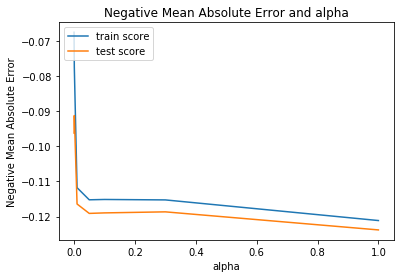

In [92]:
# plotting mean test and train scores with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float64')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [93]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'alpha': 0.001}
-0.09119348656701219


In [94]:
alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_
coeff = pd.DataFrame(lasso.coef_,X_train.columns, columns=['Coefficient'])
print(coeff.sort_values(by='Coefficient'))

                                       Coefficient
OverallCond_Fair                         -0.181691
Functional_Sev                           -0.167740
Neighborhood_MeadowV                     -0.139996
MSSubClass_2-STORY PUD - 1946 & NEWER    -0.096677
Exterior1st_BrkComm                      -0.086455
...                                            ...
MSZoning_RM                               0.333346
MSZoning_RH                               0.384103
MSZoning_RL                               0.384196
MSZoning_FV                               0.397283
Condition2_PosA                           0.447911

[273 rows x 1 columns]


In [95]:
#lets predict the R-squared value of test and train data
y_train_pred_lasso = lasso.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred_lasso))


0.9355928397043595


In [96]:
print(coeff.sort_values(by='Coefficient').head(3))

                      Coefficient
OverallCond_Fair        -0.181691
Functional_Sev          -0.167740
Neighborhood_MeadowV    -0.139996


In [97]:
print(coeff.sort_values(by='Coefficient').tail(3))

                 Coefficient
MSZoning_RL         0.384196
MSZoning_FV         0.397283
Condition2_PosA     0.447911


In [98]:
scaler.fit(X_test)

#lets predict the R-squared value of test and train data
y_test_pred = lasso.predict(X_test)

print('The accuracy of the Lasso Regression is',r2_score(y_test,y_test_pred))
print ('RMSE is: ', mean_squared_error(y_test, y_test_pred))

The accuracy of the Lasso Regression is 0.8821631645492648
RMSE is:  0.01938862751206441
